# No DNS but extra attributes



In [124]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time


The following query relies on the existence of the following view in the database
<code>
    
    create view v_sessionid_session_durn as
    select d.sessionid, max(d.frameTime) - min(d.frameTime) as session_durn from deviceLog d group by d.sessionid;
        
    create view if not exists v_pktnum_dnsq_sessionid as
        select q.pktnum, q.dnsquery, d.sessionid, d.manufacturer, d.device_type, d.frameTTL, vssd.session_durn
        from dnsqueries q
                 inner join deviceLog d on q.pktnum = d.frameNum
              inner join v_sessionid_session_durn vssd on d.sessionid = vssd.sessionid;
</code>

In [125]:
cwd = Path.cwd()
db_path = os.path.join(cwd.parent, 'Data','NetCollector.sqlite')


In [126]:
from sqlalchemy import create_engine
engine = create_engine(f'sqlite:////{db_path}')

print(engine)

sql = """

select s.srcport,
       s.dstport,
       s.lensum,
       s.pktcount,
       v.session_durn,
       v.framettl,
       v.manufacturer,
       v.device_type
from sessions s
         inner join v_session_mnf_devicetype v on s.sessionid = v.sessionid
            where v.device_type is not null

"""

df = pd.read_sql_query(sql, engine)


Engine(sqlite://///home/ricdeez/uni/NetCollector/Data/NetCollector.sqlite)


In [127]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df)


In [128]:
import numpy as np


ports = ['53', '5353', '443', '5000', '49152', '80', '123', '49153']
features = ['dstport', 'srcport']
for feature in features:
    for port in ports:
        exec('df[\'{}_is_{}\'] = np.where(df[\'{}\'] == \'{}\', 1, 0)'.format(
                feature, port, feature, port))


In [129]:
drop_columns = ['srcport', 'dstport', 'pktcount']

In [130]:
df.drop(drop_columns, axis='columns', inplace=True)

In [131]:
mapping = {k: v for v, k in enumerate((x for x in df['manufacturer'].unique() if len(x)>0),1)}
print(mapping)

{'AzureWave Technology Inc.': 1, 'Tp-Link Technologies Co.,Ltd.': 2, 'Amazon Technologies Inc.': 3, 'Physical Graph Corporation': 4, 'Samsung Electronics Co.,Ltd': 5, 'HTC Corporation': 6, 'Lifi Labs Management Pty Ltd': 7, 'Hewlett Packard': 8, 'Belkin International Inc.': 9}


**Categorical data mapping**

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative
position of that in our ordered array of unique entries

In [132]:
df['manufacturer'] = df['manufacturer'].map(mapping)

In [133]:
df.head()

,lensum,session_durn,frameTTL,manufacturer,device_type,dstport_is_53,dstport_is_5353,dstport_is_443,dstport_is_5000,dstport_is_49152,...,dstport_is_123,dstport_is_49153,srcport_is_53,srcport_is_5353,srcport_is_443,srcport_is_5000,srcport_is_49152,srcport_is_80,srcport_is_123,srcport_is_49153
0,3938199719,3111.175363,128,1,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,76807114,0.000000,128,1,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,118,3447.956344,128,1,Laptop,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,440804,3447.742173,58,2,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,625717,0.000000,58,2,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df)

In [135]:
features = ['lensum', 'session_durn', 'frameTTL']
for feature in features:
    df[feature] = (df[feature] - df[feature].mean()) / \
        (df[feature].max() - df[feature].min())

In [136]:
df.head()

,lensum,session_durn,frameTTL,manufacturer,device_type,dstport_is_53,dstport_is_5353,dstport_is_443,dstport_is_5000,dstport_is_49152,...,dstport_is_123,dstport_is_49153,srcport_is_53,srcport_is_5353,srcport_is_443,srcport_is_5000,srcport_is_49152,srcport_is_80,srcport_is_123,srcport_is_49153
0,0.999955,0.034277,0.191406,1,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.019458,-0.025407,0.191406,1,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.000045,0.040738,0.191406,1,Laptop,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.000067,0.040734,-0.084184,2,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000114,-0.025407,-0.084184,2,Laptop,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# the fun starts here...

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures


In [137]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [138]:
features = df.drop('device_type', axis=1).values

In [139]:
labels = df['device_type'].values

encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)

In [140]:
encoded_labels

array([7, 7, 7, ..., 7, 7, 7])

In [141]:
dummy_labels = np_utils.to_categorical(encoded_labels)
dummy_labels.shape

(24448, 18)

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(features, dummy_labels, test_size=0.2, random_state=42)

In [143]:
print(len(dummy_labels), len(Y_train), len(Y_test), sep='::')

24448::19558::4890


In [151]:
model = Sequential([
                    Dense(32, input_dim=features.shape[1], activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(dummy_labels.shape[1], activation='softmax')
                  ])
model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])

In [152]:
history = model.fit(X_train, Y_train, epochs=120, shuffle=True, verbose=2)

Epoch 1/120
 - 0s - loss: 1.2094 - accuracy: 0.6362
Epoch 2/120
 - 0s - loss: 0.7122 - accuracy: 0.7667
Epoch 3/120
 - 0s - loss: 0.6346 - accuracy: 0.7777
Epoch 4/120
 - 0s - loss: 0.5969 - accuracy: 0.7904
Epoch 5/120
 - 0s - loss: 0.5702 - accuracy: 0.8019
Epoch 6/120
 - 0s - loss: 0.5517 - accuracy: 0.8088
Epoch 7/120
 - 0s - loss: 0.5331 - accuracy: 0.8197
Epoch 8/120
 - 0s - loss: 0.5145 - accuracy: 0.8331
Epoch 9/120
 - 0s - loss: 0.4984 - accuracy: 0.8370
Epoch 10/120
 - 0s - loss: 0.4849 - accuracy: 0.8440
Epoch 11/120
 - 0s - loss: 0.4675 - accuracy: 0.8478
Epoch 12/120
 - 0s - loss: 0.4586 - accuracy: 0.8497
Epoch 13/120
 - 0s - loss: 0.4490 - accuracy: 0.8491
Epoch 14/120
 - 0s - loss: 0.4422 - accuracy: 0.8499
Epoch 15/120
 - 0s - loss: 0.4357 - accuracy: 0.8509
Epoch 16/120
 - 0s - loss: 0.4283 - accuracy: 0.8514
Epoch 17/120
 - 0s - loss: 0.4230 - accuracy: 0.8548
Epoch 18/120
 - 0s - loss: 0.4227 - accuracy: 0.8550
Epoch 19/120
 - 0s - loss: 0.4168 - accuracy: 0.8543
Ep

In [153]:
model.metrics_names

['loss', 'accuracy']

In [154]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

In [155]:
print(f'Loss = {loss}, Accuracy={accuracy}')

Loss = 0.4110249174884492, Accuracy=0.8660531640052795


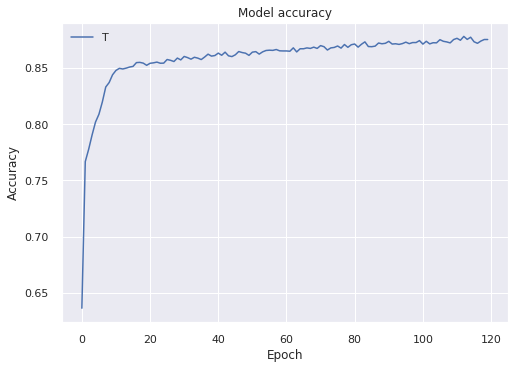

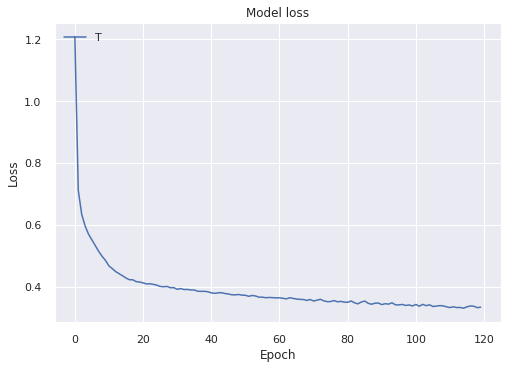

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

In [150]:
import pandas_profiling
pandas_profiling.ProfileReport(df)